In [2]:
!pip install wordcloud

     ---------------------------------------- 0.0/152.9 kB ? eta -:--:--
     -------------------------------------- 152.9/152.9 kB 4.5 MB/s eta 0:00:00


In [5]:
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np # linear algebra
import pandas as pd
from pprint import pprint
from datetime import datetime
import collections
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\roman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\roman\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\roman\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
file_name = 'tweets_labelled_09042020_16072020.csv'
data = pd.read_csv(file_name, sep=';').set_index('id')
data.shape
data.to_csv('tweet.csv')


Updated 2021/5/11

In [7]:
data.head()

,created_at,text,sentiment
id,,,
77522,2020-04-15 01:03:46+00:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive
661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative
413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,positive
760262,2020-07-03 19:39:35+00:00,RT @bentboolean: How much of Amazon's traffic ...,positive
830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive


## Quick view of tweets

In [8]:
for i in range(5):
    pprint(data.iat[i,1])

('RT @RobertBeadles: Yo💥\n'
 'Enter to WIN 1,000 Monarch Tokens✅\n'
 '\n'
 'US Stock Market Crashes &amp; what we can LEARN from them PT3!\n'
 '\n'
 'RETWEET, WATCH video…')
('#SriLanka surcharge on fuel removed!\n'
 '⛽📉\n'
 'The surcharge of Rs.26 imposed on diesel and petrol has been revoked with '
 'effect from midnight on June 23 says Power, Energy and Transport Minister '
 'Mahinda. Amaraweera -Adaderana-\n'
 '\n'
 '#lka #FuelPrices #taxes #economy #stocks #StockMarket')
('Net issuance increases to fund fiscal programs &gt; yields spike higher &gt; '
 'risk off: #stocks and #EMFX correct lower &gt; #Fed comes in with #YCC &gt; '
 'stocks to new all time highs with 20% unemployment and -25% GDP. Fin.')
("RT @bentboolean: How much of Amazon's traffic is served by Fastly? Help us "
 'find out by running this tool from your IP address: https://t.co…')
('$AMD Ryzen 4000 desktop CPUs looking ‘great’ and on track to launch in 2020 '
 'https://t.co/y7yYvXOVYJ #madtweets #stocks #cnbc #AMD

In [9]:
ticker_pattern = re.compile(r'(^\$[A-Z]+|^\$ES_F)')
ht_pattern = re.compile(r'#\w+')

ticker_dic = collections.defaultdict(int)
ht_dic = collections.defaultdict(int)

for text in data['text']:
    for word in text.split():
        if ticker_pattern.fullmatch(word) is not None:
            ticker_dic[word[1:]] += 1
        
        word = word.lower()
        if ht_pattern.fullmatch(word) is not None:
            ht_dic[word] += 1

Tweet texts contain some ticker symbols  
> For exsample, $AMD in 5th row

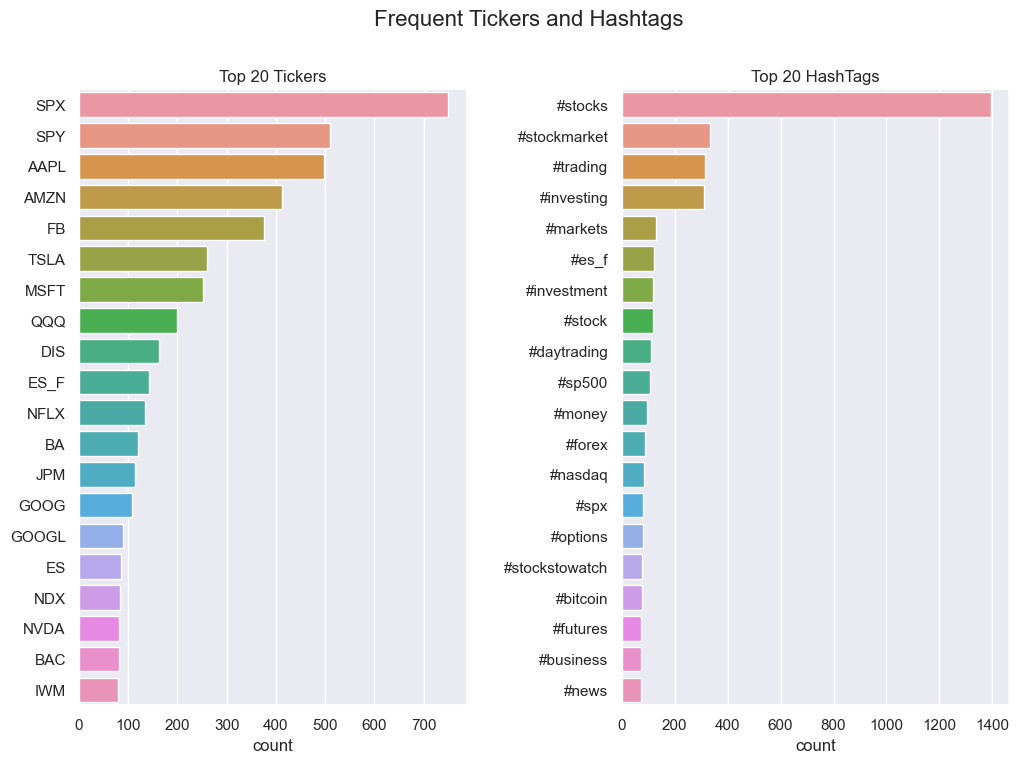

In [10]:
ticker_df = pd.DataFrame.from_dict(
    ticker_dic, orient='index').rename(columns={0:'count'})\
    .sort_values('count', ascending=False).head(20)
    
ht_df = pd.DataFrame.from_dict(
    ht_dic, orient='index').rename(columns={0:'count'})\
    .sort_values('count', ascending=False).head(20)

fig, ax = plt.subplots(1, 2, figsize=(12,8))
plt.suptitle('Frequent Tickers and Hashtags', fontsize=16)
plt.subplots_adjust(wspace=0.4)

sns.barplot(x=ticker_df['count'], y=ticker_df.index, orient='h', ax=ax[0])
ax[0].set_title('Top 20 Tickers')

sns.barplot(x=ht_df['count'], y=ht_df.index, orient='h', ax=ax[1])
ax[1].set_title('Top 20 HashTags')

plt.show()

## PreProccess for WordCloud  
### * delete emoji, handle, URL,...
### * lemmatize
### * delete stop_word including 'RT'

In [11]:
charonly = re.compile(r'[^a-zA-Z\s]')
handle_pattern = re.compile(r'@\w+')
emoji_pattern = re.compile("["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        "]+", flags=re.UNICODE)
url_pattern = re.compile(
    'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
pic_pattern = re.compile('pic\.twitter\.com/.{10}')
special_code = re.compile(r'(&amp;|&gt;|&lt;)')
tag_pattern = re.compile(r'<.*?>')

STOPWORDS = set(stopwords.words('english')).union(
    {'rt', 'retweet', 'RT', 'Retweet', 'RETWEET'})

lemmatizer = WordNetLemmatizer()

def hashtag(phrase):
    return ht_pattern.sub(' ', phrase)

def remove_ticker(phrase):
    return ticker_pattern.sub('', phrase)
    
def specialcode(phrase):
    return special_code.sub(' ', phrase)

def emoji(phrase):
    return emoji_pattern.sub(' ', phrase)

def url(phrase):
    return url_pattern.sub('', phrase)

def pic(phrase):
    return pic_pattern.sub('', phrase)

def html_tag(phrase):
    return tag_pattern.sub(' ', phrase)

def handle(phrase):
    return handle_pattern.sub('', phrase)

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    
    # DIS, ticker symbol of Disney, is interpreted as the plural of "DI" 
    # in WordCloud, so I converted it to Disney
    phrase = re.sub('DIS', 'Disney', phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"(he|He)\'s", "he is", phrase)
    phrase = re.sub(r"(she|She)\'s", "she is", phrase)
    phrase = re.sub(r"(it|It)\'s", "it is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"(\'ve|has)", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def onlychar(phrase):
    return charonly.sub('', phrase)

def remove_stopwords(phrase):
    return " ".join([word for word in str(phrase).split()\
                     if word not in STOPWORDS])

def tokenize_stem(phrase):   
    tokens = word_tokenize(phrase)
    stem_words =[]
    for token in tokens:
        word = lemmatizer.lemmatize(token)
        stem_words.append(word)        
    buf = ' '.join(stem_words)    
    return buf

In [12]:
def arrange_text(ds):
    ds['text2'] = ds['text'].apply(emoji)
    ds['text2'] = ds['text2'].apply(handle)
    ds['text2'] = ds['text2'].apply(specialcode)
    ds['text2'] = ds['text2'].apply(hashtag)
    ds['text2'] = ds['text2'].apply(url)
    ds['text2'] = ds['text2'].apply(pic)
    ds['text2'] = ds['text2'].apply(html_tag)
    ds['text2'] = ds['text2'].apply(onlychar)
    ds['text2'] = ds['text2'].apply(decontracted)
    ds['text2'] = ds['text2'].apply(onlychar)
    ds['text2'] = ds['text2'].apply(tokenize_stem)
    ds['text2'] = ds['text2'].apply(remove_stopwords)

In [13]:
arrange_text(data)

## Quick view of preprocessed tweets

In [14]:
for i in range(5):
    pprint(data.iat[i,3])

'Yo Enter WIN Monarch Tokens US Stock Market Crashes LEARN PT WATCH video'
('surcharge fuel removed The surcharge Rs imposed diesel petrol revoked effect '
 'midnight June say Power Energy Transport Minister Mahinda Amaraweera '
 'Adaderana')
('Net issuance increase fund fiscal program yield spike higher risk correct '
 'lower come stock new time high unemployment GDP Fin')
'How much Amazons traffic served Fastly Help u find running tool IP address'
'AMD Ryzen desktop CPUs looking great track launch'


## WordCloud

> "DIS", ticker of The Walt Disney Company, is interpreted as the plural of "DI" in WordCloud, so I converted it to "Disney"

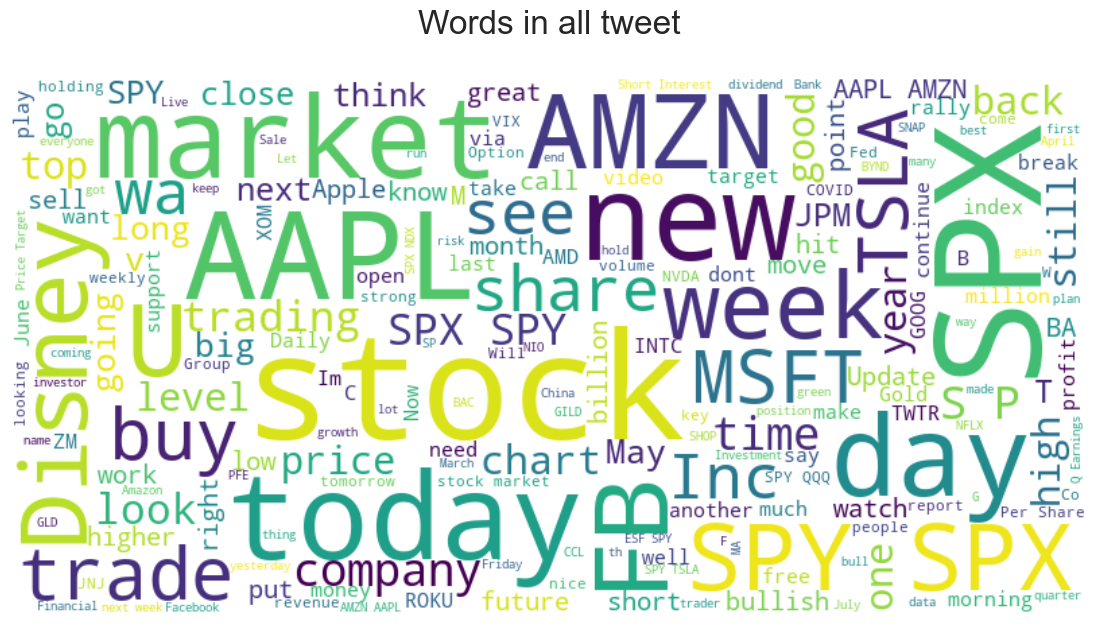

In [21]:
words = ' '.join([text for text in data['text2']])
wordcloud = WordCloud(
    width=800, height=400, background_color='white', max_font_size=110)\
    .generate(words)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Words in all tweet\n', fontsize=24)
plt.axis('off')
plt.show()

### Too much Tickers!!  
### So I created WordCloud without Ticker because the words that symbolize sentiment are not obvious.

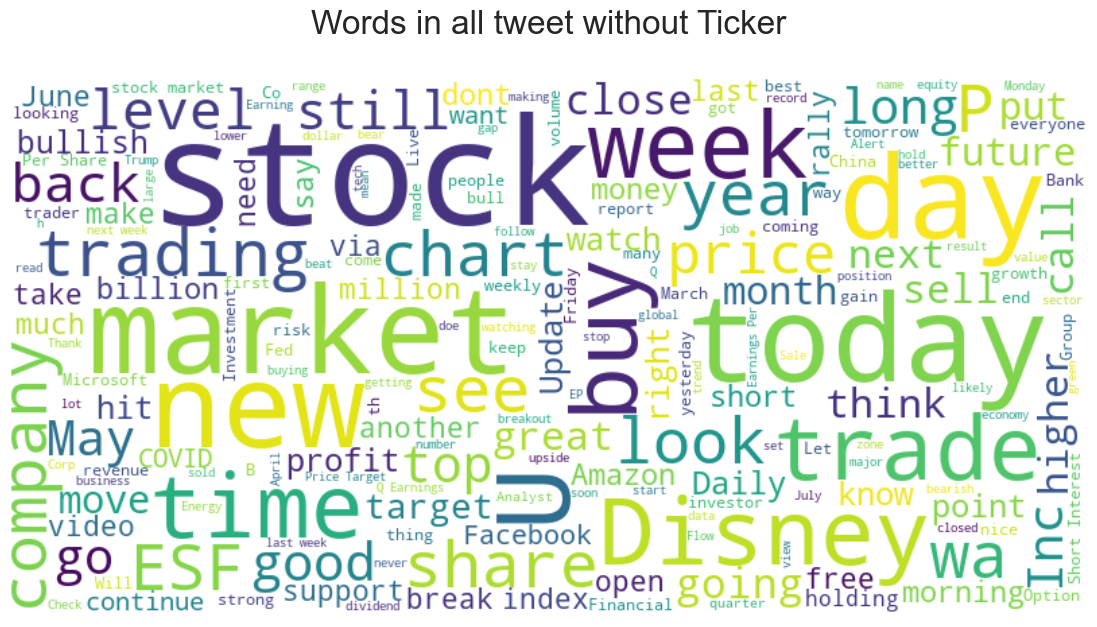

In [16]:
not_ticker = [] # list of words except for Ticker

for text in data['text2']:
    for word in text.split():
        if word.upper() not in ticker_dic:
            not_ticker.append(word)
            
words = ' '.join([word for word in not_ticker])
wordcloud = WordCloud(
    width=800, height=400, background_color='white', max_font_size=110).\
    generate(words)
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Words in all tweet without Ticker\n', fontsize=24)
plt.axis('off')
plt.show()

### WordCloud by sentiment  
Tickers are excluded, hereafter.

In [17]:
def wordcloud_by_sentiment(sentiment):
    not_ticker = []

    for text in data[data['sentiment']==sentiment]['text2']:
        for word in text.split():
            if word.upper() not in ticker_dic:
                not_ticker.append(word.lower())

    words = ' '.join([word for word in not_ticker])
    wordcloud = WordCloud(
        width=800, height=400, background_color='white', max_font_size=110, max_words=100).\
        generate(words)
    plt.figure(figsize=(14, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title('Words in '+ sentiment.capitalize() + ' tweets\n', fontsize=32)
    plt.axis('off')
    plt.show()

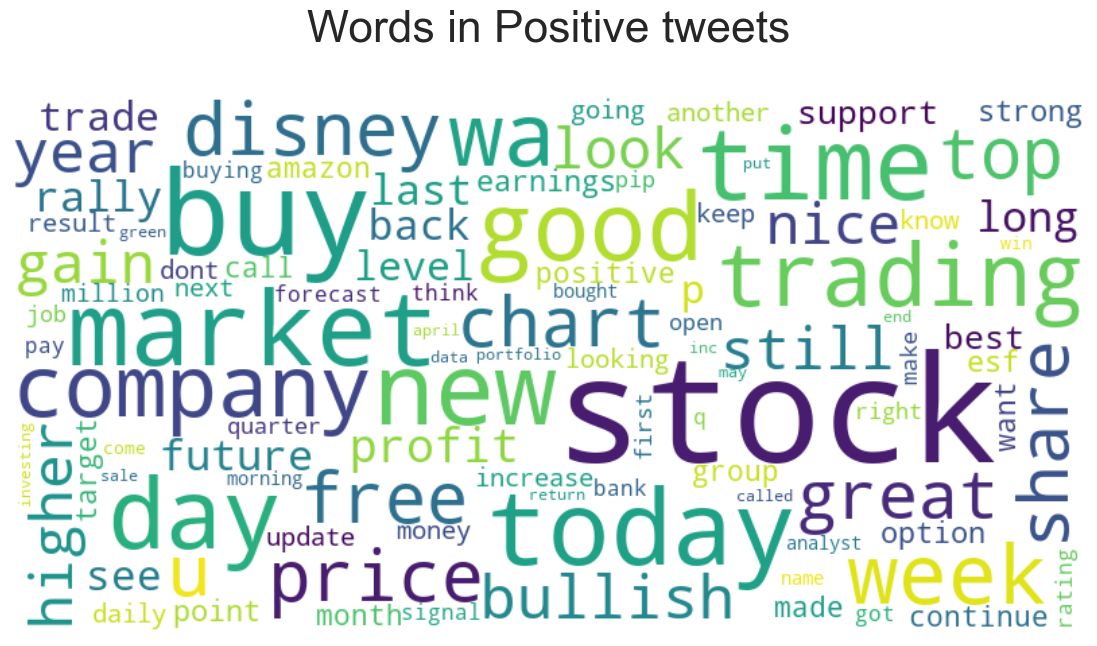

In [18]:
wordcloud_by_sentiment('positive')

"buy", "bullish", "good", "higher", "rally",...

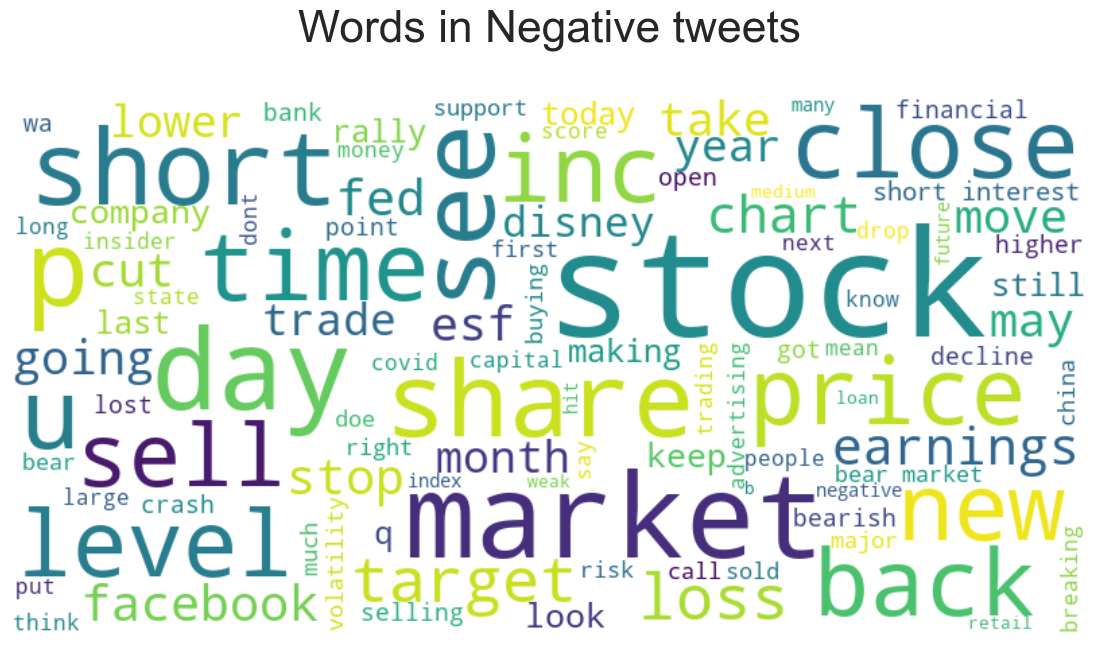

In [19]:
wordcloud_by_sentiment('negative')

"sell", "short", "loss", "lower", "bearish", ...  
Particularly noteworthy are the words in small fonts, such as "volatility", "risk", "short interest", "covid",...

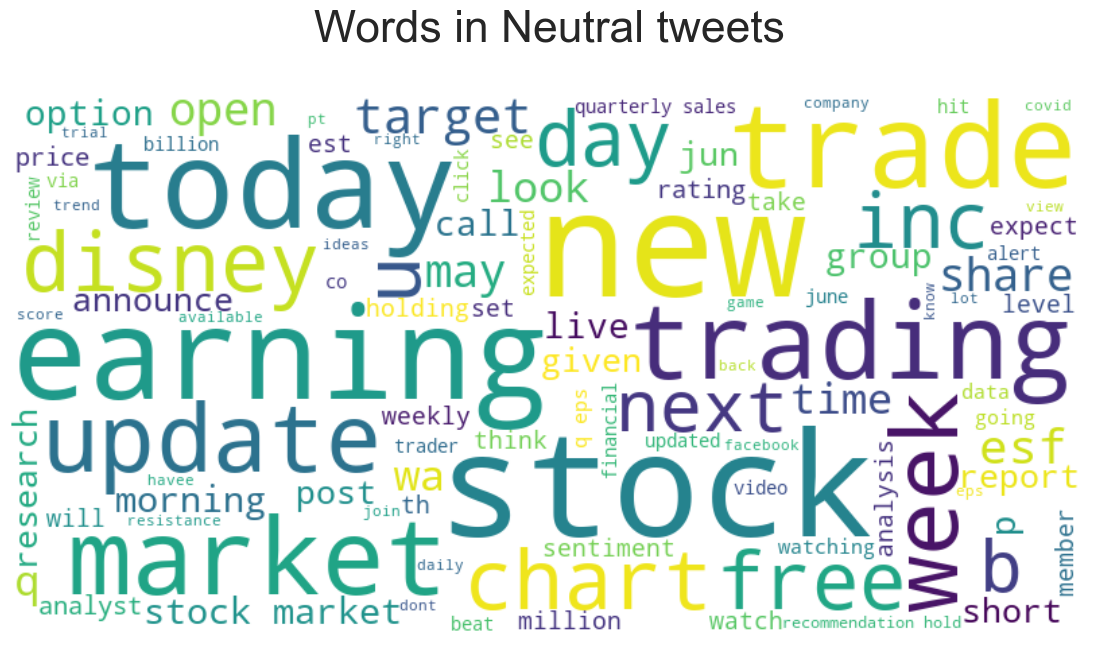

In [20]:
wordcloud_by_sentiment('neutral')